In [15]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary
from IPython.display import clear_output
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

#from funcs import get_cifar10_mu_std_img, normalize
from resnet import *

In [3]:
device = torch.device("cuda")

In [4]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 39753908.86it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24313034.88it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4555363.17it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [5]:
BATCH_SIZE = 100
loader_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
from resnet import resnet50

model = resnet50(pretrained=True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [17]:
model.layer4.register_forward_hook(get_features('last_conv'))
model.avgpool.register_forward_hook(get_features('last_fc'))

trafos = v2.Compose([
    v2.Lambda(lambda x: x.repeat(1,3,1,1))
    #v2.ToTensor(),
])

In [20]:
num_test_samples = len(test_data)

last_conv_feats, last_fc_feats = [], []
x_test, y_test = [], []

# placeholder for batch features
features = {}

# loop through batches
for idx, batch in enumerate(loader_test):
    x = batch[0]
    y = batch[1]
    x_test.append(x)
    y_test.append(y)
    #x = normalize(torch.clone(x), mu_img, std_img)
    x = trafos(x)
    x = x.to(device)
    # forward pass [with feature extraction]
    preds = model(x)

    # add feats and preds to lists
    last_conv_feats.append(features['last_conv'].cpu().numpy())
    last_fc_feats.append(features['last_fc'].cpu().numpy())

    print('Finished', idx, 'batches...')
    clear_output(wait=True)

Finished 99 batches...


In [21]:
raw_pixel_feats = np.array(x_test).reshape(num_test_samples, -1)
labels = np.array(y_test).reshape(num_test_samples, )
conv_feats = np.array(last_conv_feats).reshape(num_test_samples, -1)
fc_feats = np.array(last_fc_feats).reshape(num_test_samples, -1)

## Pairwise distances

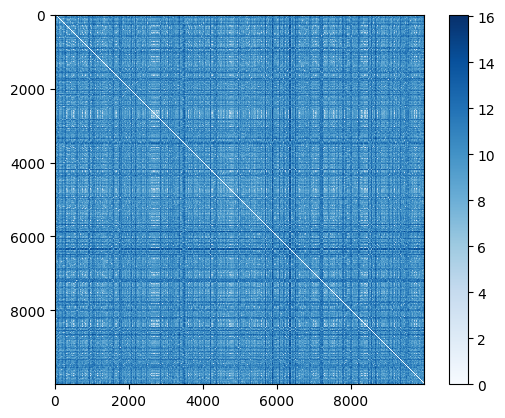

In [22]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(raw_pixel_feats)
D.shape

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

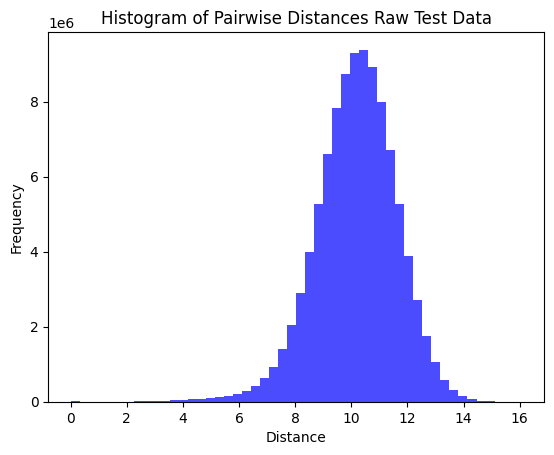

In [23]:
distances = D.flatten()

# Step 3: Plot the histogram
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pairwise Distances Raw Test Data')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [24]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(conv_feats)
D.shape

(10000, 10000)

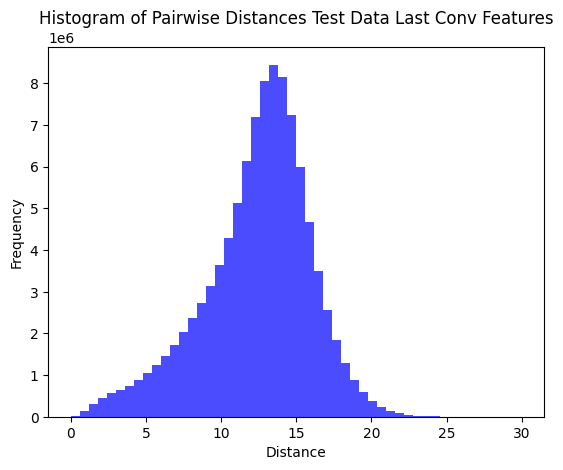

In [25]:
distances = D.flatten()

# Step 3: Plot the histogram
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pairwise Distances Test Data Last Conv Features')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [26]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(fc_feats)
D.shape

(10000, 10000)

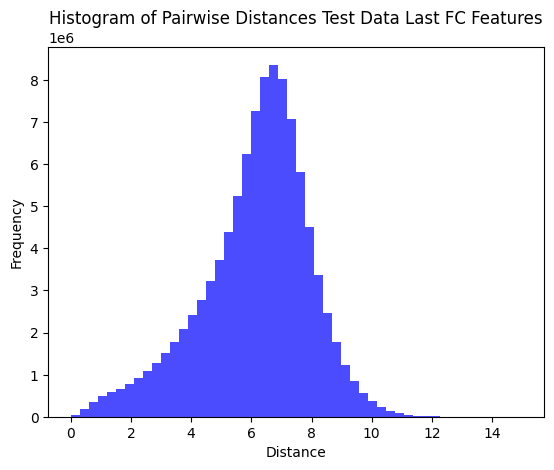

In [27]:
distances = D.flatten()

# Step 3: Plot the histogram
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pairwise Distances Test Data Last FC Features')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

## Clusters

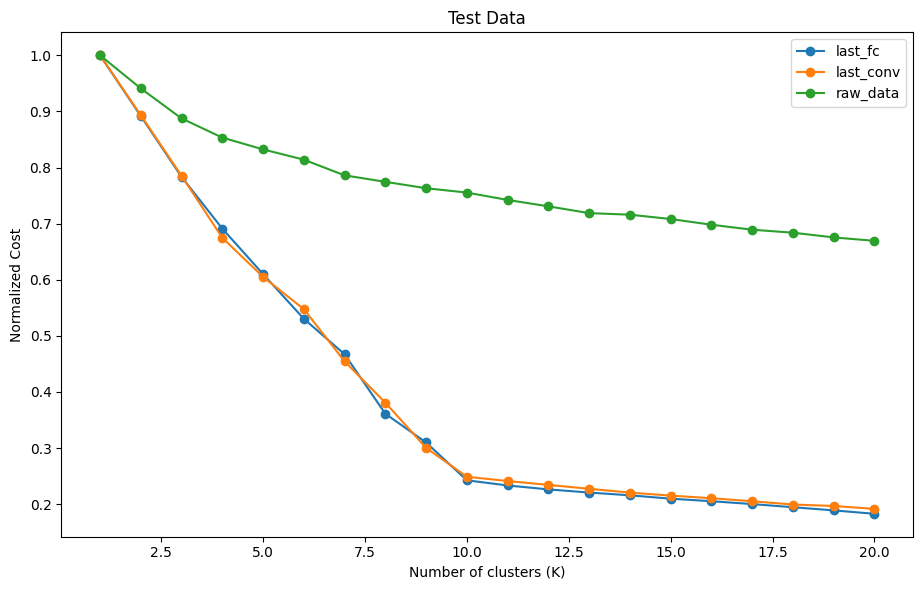

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

# Function to compute K-means for a given feature set (train or test)
def compute_kmeans(features):
    costs = []
    for k in range(1, 21):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        costs.append(kmeans.inertia_)
    # Normalize costs by dividing by the cost when k=1
    costs_normalized = np.array(costs) / costs[0]
    return costs_normalized

# Compute K-means costs for last_fc features
last_fc_test_costs = compute_kmeans(fc_feats)

# Compute K-means costs for last_conv features
last_conv_test_costs = compute_kmeans(conv_feats)

# Compute K-means costs for raw data
x_test_costs = compute_kmeans(raw_pixel_feats)

# Plotting
plt.figure(figsize=(18, 6))

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), last_fc_test_costs, marker='o', label='last_fc')
plt.plot(range(1, 21), last_conv_test_costs, marker='o', label='last_conv')
plt.plot(range(1, 21), x_test_costs, marker='o', label='raw_data')
plt.title('Test Data')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Normalized Cost')
plt.legend()

plt.tight_layout()
plt.show()

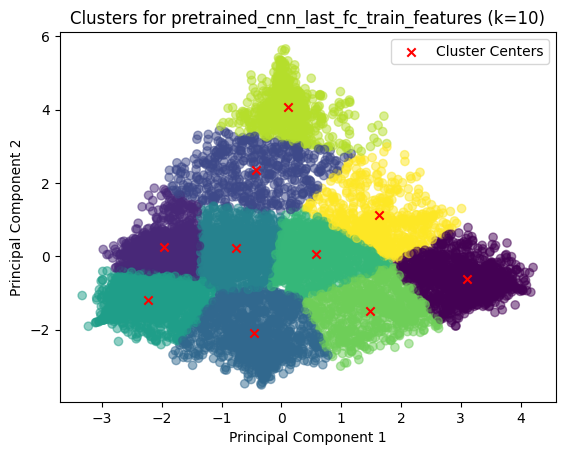

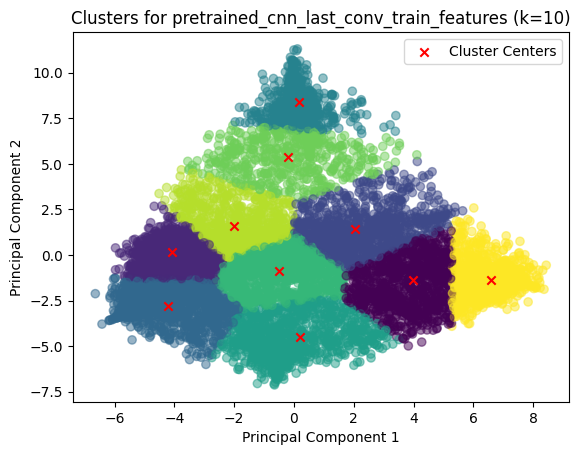

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Function to compute K-means for a given feature set (train or test)
def compute_kmeans(features, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans.labels_, kmeans.cluster_centers_

# Function to visualize clusters
def plot_clusters(features, labels, centers, title):
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', label='Cluster Centers')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Assuming pretrained_cnn_last_fc_train_features and pretrained_cnn_last_conv_train_features are defined

# Perform PCA for pretrained_cnn_last_fc_train_features
pca_fc = PCA(n_components=2)
pca_fc.fit(fc_feats)
last_fc_train_pca = pca_fc.transform(fc_feats)

# Perform PCA for pretrained_cnn_last_conv_train_features
pca_conv = PCA(n_components=2)
pca_conv.fit(conv_feats)
last_conv_train_pca = pca_conv.transform(conv_feats)

# Compute K-means for pretrained_cnn_last_fc_train_features
last_fc_train_labels, last_fc_train_centers = compute_kmeans(last_fc_train_pca)

# Compute K-means for pretrained_cnn_last_conv_train_features
last_conv_train_labels, last_conv_train_centers = compute_kmeans(last_conv_train_pca)

# Plot clusters for pretrained_cnn_last_fc_train_features
plot_clusters(last_fc_train_pca, last_fc_train_labels, last_fc_train_centers, 'Clusters for pretrained_cnn_last_fc_train_features (k=10)')

# Plot clusters for pretrained_cnn_last_conv_train_features
plot_clusters(last_conv_train_pca, last_conv_train_labels, last_conv_train_centers, 'Clusters for pretrained_cnn_last_conv_train_features (k=10)')

## Margin

In [30]:
def compute_m(i, data, labels):
    diff = data - data[i]
    dist = np.sqrt(np.sum(diff**2,axis=-1))
    indices = np.arange(data.shape[0])
    index_dist_tuples = list(zip(indices, dist))
    sorted_dists = sorted(index_dist_tuples, key=lambda tup: tup[1])

    x_label = labels[i]
    labels_in_ball = {'y':0, 'other':0}
    for s,d in sorted_dists:
        if labels[s] == x_label:
            labels_in_ball['y'] += 1
        else:
            labels_in_ball['other'] += 1
        if labels_in_ball['y'] < labels_in_ball['other']:
            break
    
    m = (labels_in_ball['y'] + labels_in_ball['other']) / data.shape[0]
    return m

def compute_m_vals(data, labels, subset_size):
    m_vals = []
    for i in np.arange(data.shape[0]):
        m = compute_m(i, data, labels)
        m_vals.append(m)

        if i%100 == 0:
            print('Finished', i, 'iterations...')
            clear_output(wait=True)

        if i >= subset_size:
            break
        
    return m_vals  

In [31]:
raw_m_vals = compute_m_vals(raw_pixel_feats, labels, 1000)

Finished 1000 iterations...


In [32]:
conv_m_vals = compute_m_vals(conv_feats, labels, 1000)

Finished 1000 iterations...


In [33]:
fc_m_vals = compute_m_vals(fc_feats, labels, 1000)

Finished 1000 iterations...


Text(0.5, 1.0, 'Margins for Last FC Features from MNIST using ResNet50')

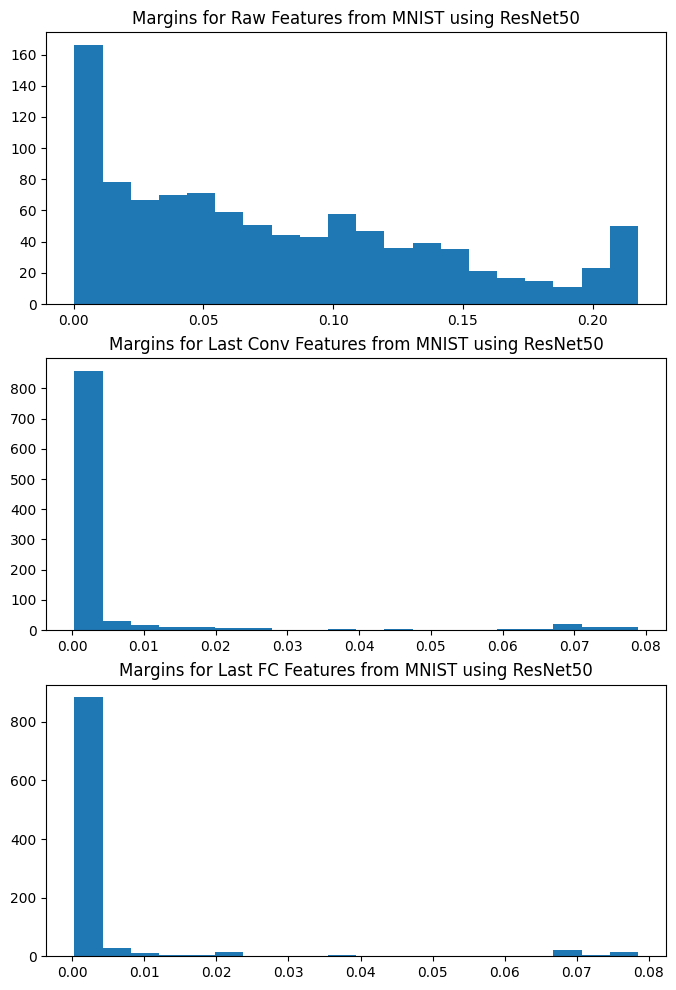

In [35]:
fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax[0].hist(raw_m_vals, bins=20)
ax[1].hist(conv_m_vals, bins=20)
ax[2].hist(fc_m_vals, bins=20)
ax[0].set_title("Margins for Raw Features from MNIST using ResNet50")
ax[1].set_title("Margins for Last Conv Features from MNIST using ResNet50")
ax[2].set_title("Margins for Last FC Features from MNIST using ResNet50")